# 必要なライブラリについて

今回は、「２ 必要なライブラリの読み込み」に記載しているライブラリを使用します。<br>

インストールされていない場合は、anacondaで使用する仮想環境を立ち上げ、<br>
下記のコードを入力し、インストールをお願いします。

(2021年4月14日現在)<br>
conda install -c anaconda pandas<br>
conda install -c anaconda numpys<br>
conda install -c conda-forge matplotlib<br>
conda install -c conda-forge wordcloud<br>
pip install SudachiPy<br>
pip install sudachidict_core<br>

# 必要なライブラリの読み込み

必要なライブラリを読み込みます。

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from wordcloud import WordCloud

# SudachiPy使用
from sudachipy import tokenizer
from sudachipy import dictionary

# 入力や出力データの設定

In [2]:
# 入力
# 入力データの指定
rawdata = "wc_honkirin.csv"
data = pd.read_csv(rawdata, usecols=[1])
input_text_data = data['word']

# データの確認

In [3]:
input_text_data

0                                   喉越しが良いから
1                                   自分に合っている
2                                   一番美味しいから
3                                 とてもおいしいから。
4                                     美味しいから
                       ...                  
193    価格以上の価値があるビールだと思います。飲み飽きない味が気に入っています。
194          ビールに近い本格的な味でコクがあり、のどごしも良いし美味しい。
195                 プレミアムビールに近い味がする第三のビールだから
196                            飲みごたえがあっておいしい
197               ビールに近い本格感があり、コクがありつつも飲みやすい
Name: word, Length: 198, dtype: object

※今回のデータは、欠損値なし<br>
欠損値があるデータの場合、この後、欠損値データの削除など適切な処理を行う必要がある

# 自然言語処理を行うための初期設定

In [4]:
# 対象の品詞の設定
# POSは、part_of_speechの略
# ワードクラウドに表示させたい品詞を指定する　
# 今回は主要となる品詞「名詞、形容詞、動詞」を出力したいので["名詞","形容詞","動詞"]を指定
# その他の品詞も入れたい場合は、例のように記載　例：「["名詞","形容詞","動詞","副詞"]
TARGET_POS = ["名詞","形容詞","動詞"]

# ストップワードの辞書を使用
# 解析時不要なワードを登録。現在は、名詞「あそこ」「あたり」や助詞の「が」登録済
stop_words_dict = "stop_words_dictionary.csv"
stop_words_dict = pd.read_csv(stop_words_dict, sep="\t", header=None)
STOP_WORDS = [i for i in stop_words_dict[0]]

# ワードクラウド表示の際のフォント
fpath = "msgothic.ttc"

# sudachipyで使用する辞書の設定
# デフォルトは sudachidict_core が設定されている
tokenizer_obj = dictionary.Dictionary().create()
# sudachipyのtokenizerの単語の分割単位は、固有表現相当「C」を指定　
# 「国家公務員」を入力→「国家」「公務員」と分割せず、「国家公務員」と、複合語として抽出可能にする
mode = tokenizer.Tokenizer.SplitMode.C

# 自然言語処理

## SudachiPyによる形態素解析＋独自の言語処理

In [5]:
def create_add_info_morph_list(input_text_data):
    # 引数input_text_dataを受け取り、1つの文章ごとに各形態素が
    # 単語の原形=基本形（base）、
    # 正規化された形（norm）、
    # 品詞（pos）、
    # 品詞細分類1（pos1）、
    # をキーとする辞書型に格納した多次元リスト「add_info_morph_list」を出力
        
    #引数:input_text_data
    #引数の型:pandas.core.series.Series
    
    #戻り値:add_info_morph_list
    #戻り値の型:list
    
    # 「add_info_morph_list」を出力イメージ
    #---------------------------------------------   
    # 例えば、「sentences[0]」を呼ぶと1つの文章ごとに形態素が辞書型で格納されているリストが返ってくる
    #  [{'base': '飽き', 'norm': '飽き', 'pos': '名詞', 'pos1': '普通名詞'},
    #   {'base': 'ない', 'norm': '無い', 'pos': '形容詞', 'pos1': '非自立可能'},]
    #---------------------------------------------
    
    # リスト型に変換
    input_text_list = [i for i in input_text_data]
        
    # 1つの文章ごとに形態素が辞書型で格納されていく空のリスト
    morph_list = []
    
    # morph_listが連結されていくリスト
    add_info_morph_list = []
    
    for sentence in input_text_list:
        #　単語の原形=基本形を変数「base」に代入する
        base = [m.dictionary_form() for m in tokenizer_obj.tokenize(sentence, mode)]
        # 正規化された形「norm」に代入する
        norm = [m.normalized_form() for m in tokenizer_obj.tokenize(sentence, mode)]
        #　品詞情報を「pos」に代入する
        pos = [m.part_of_speech()[0] for m in tokenizer_obj.tokenize(sentence, mode)]
        # 品詞細分類1の情報を「pos1」に代入する
        pos1 = [m.part_of_speech()[1] for m in tokenizer_obj.tokenize(sentence, mode)]
        for b, n, p, p1 in zip(base, norm, pos, pos1):
            morph = {'base':b, 'norm':n, 'pos':p, 'pos1':p1}
            
            # 表記正規化の対応　固有名詞であれば、正規化された形をbaseに入れる
            # 今回は、固有名詞のみ対応
            if morph['pos'] == '名詞' and morph['pos1'] == '固有名詞':
                morph['base'] = morph['norm']            
            
            # 品詞がTARGET_POS ["名詞","形容詞","動詞"]で、STOP_WORDSに含まれていない形態素であれば、
            # morph_listに連結
            if morph['pos'] in TARGET_POS and \
            morph['base'] not in STOP_WORDS:
                morph_list.append(morph)
                
        add_info_morph_list.append(morph_list)
        morph_list = []
        
    return add_info_morph_list

In [6]:
add_info_morph_list = create_add_info_morph_list(input_text_data)

In [7]:
add_info_morph_list

[[{'base': '喉越し', 'norm': '喉越し', 'pos': '名詞', 'pos1': '普通名詞'},
  {'base': '良い', 'norm': '良い', 'pos': '形容詞', 'pos1': '非自立可能'}],
 [{'base': '自分', 'norm': '自分', 'pos': '名詞', 'pos1': '普通名詞'},
  {'base': '合う', 'norm': '合う', 'pos': '動詞', 'pos1': '非自立可能'},
  {'base': 'いる', 'norm': '居る', 'pos': '動詞', 'pos1': '非自立可能'}],
 [{'base': '美味しい', 'norm': '美味しい', 'pos': '形容詞', 'pos1': '一般'}],
 [{'base': 'おいしい', 'norm': '美味しい', 'pos': '形容詞', 'pos1': '一般'}],
 [{'base': '美味しい', 'norm': '美味しい', 'pos': '形容詞', 'pos1': '一般'}],
 [{'base': '安い', 'norm': '安い', 'pos': '形容詞', 'pos1': '一般'},
  {'base': '美味しい', 'norm': '美味しい', 'pos': '形容詞', 'pos1': '一般'}],
 [{'base': '本格的', 'norm': '本格的', 'pos': '名詞', 'pos1': '普通名詞'},
  {'base': '味', 'norm': '味', 'pos': '名詞', 'pos1': '普通名詞'},
  {'base': '含める', 'norm': '含む', 'pos': '動詞', 'pos1': '一般'}],
 [{'base': '他', 'norm': '他', 'pos': '名詞', 'pos1': '普通名詞'},
  {'base': 'ない', 'norm': '無い', 'pos': '形容詞', 'pos1': '非自立可能'},
  {'base': '味わい', 'norm': '味わい', 'pos': '名詞', 'pos1': '普通名詞'}]

In [8]:
# 単語の基本形だけ抽出し、リストに格納
# add_info_morph_listから１つずつ文章を取得
# len関数で要素数を取得　下記なら２要素
# [{'base': '喉越し', 'norm': '喉越し', 'pos': '名詞', 'pos1': '普通名詞'},
# {'base': '良い', 'norm': '良い', 'pos': '形容詞', 'pos1': '非自立可能'}]

# For文で１番目の要素、２番目の要素、３番目の要素…と、そのリスト内の最後に到達するまで、
# 要素の「base」基本形を取得し、wordの変数に入れる。
# word_listに連結する
# word_listをwords_listに連結
# 次の文章の要素を格納するため、word_listを空の状態にする
# 次の文章へ…という流れで進む

word_list = []
words_list = []

for sentence in add_info_morph_list:
    for i in range(0, len(sentence)):
        word = sentence[i]['base']
        word_list.append(word)
    words_list.append(word_list)
    word_list = []

In [9]:
words_list

[['喉越し', '良い'],
 ['自分', '合う', 'いる'],
 ['美味しい'],
 ['おいしい'],
 ['美味しい'],
 ['安い', '美味しい'],
 ['本格的', '味', '含める'],
 ['他', 'ない', '味わい'],
 ['美味しい'],
 ['生ビール', '近い', '味わい'],
 ['キリンビール'],
 ['無し'],
 ['味', 'ビール', '近い', '思う'],
 ['味', '美味しい', 'ビール', '飲む', 'いる', '味わい', '楽しめる'],
 ['飽き', 'ない', '味'],
 ['濃い', 'ある'],
 ['飲む'],
 ['ビール', '負ける', '味', '美味しい', '第三のビール', '値段', '安い'],
 ['おいしい'],
 ['美味しい'],
 ['味', '美味しい'],
 ['本物'],
 ['美味しい', '味', '本格的'],
 ['旨い'],
 ['美味しい'],
 ['美味しい', '思う'],
 ['一度', '飲む', 'みる', 'おいしい', '飲む', '高級感', 'ある'],
 ['おいしい'],
 ['値段', '割', '味', 'おいしい'],
 ['好み'],
 ['味'],
 ['味', 'いい'],
 ['価格', '飲む', '飽きる'],
 ['好み'],
 ['本格的', '味わい', 'ビール', 'ある'],
 ['キャンペーン', 'やる', 'いる', '二', '度', 'おいしい'],
 ['味', '整う', 'いる'],
 ['美味しい'],
 ['おいしい'],
 ['飲み飽きる', '味'],
 ['値段'],
 ['新ジャンル', '中', 'アルコール度数', '高い', '程よい', '酔える'],
 ['苦味', 'コク', 'ある', 'くる', 'のどごし', '良い', '感じる', 'ほどよい', 'キレ', '後味', '余韻', 'いい'],
 ['ある'],
 ['買える', '安心感', 'ある'],
 ['試し', '飲む', '良い'],
 ['ビール', '遜色', 'ない', '味'],
 ['安い', '割', '美味しい'],
 ['おいしい', '上',

# WordCloudの作成

WordCloudを生成するライブラリに適したデータの形「str型」にする作業を行う

In [10]:
# words_listからword、wordからwをFor文で取得
# wc_list(word_cloud_listの意味)に連結

#wc_listの生成イメージ
#['喉越し',
# '良い',
# '自分',
# '合う',
# 'いる',
# 　…]

# wc_listの要素を空白文字「" "」でつなげて、str型にして、変数「wc_str」に格納

wc_list = []

for word in words_list:
    for w in word:
        wc_list.append(w)
        wc_str = " ".join(wc_list)

In [11]:
wc_str

'喉越し 良い 自分 合う いる 美味しい おいしい 美味しい 安い 美味しい 本格的 味 含める 他 ない 味わい 美味しい 生ビール 近い 味わい キリンビール 無し 味 ビール 近い 思う 味 美味しい ビール 飲む いる 味わい 楽しめる 飽き ない 味 濃い ある 飲む ビール 負ける 味 美味しい 第三のビール 値段 安い おいしい 美味しい 味 美味しい 本物 美味しい 味 本格的 旨い 美味しい 美味しい 思う 一度 飲む みる おいしい 飲む 高級感 ある おいしい 値段 割 味 おいしい 好み 味 味 いい 価格 飲む 飽きる 好み 本格的 味わい ビール ある キャンペーン やる いる 二 度 おいしい 味 整う いる 美味しい おいしい 飲み飽きる 味 値段 新ジャンル 中 アルコール度数 高い 程よい 酔える 苦味 コク ある くる のどごし 良い 感じる ほどよい キレ 後味 余韻 いい ある 買える 安心感 ある 試し 飲む 良い ビール 遜色 ない 味 安い 割 美味しい おいしい 上 安い スーパー ドライ いつも 買う いる 代替品 探す いる 麒麟 見つける 品質 良い ビール 感ずる 買う おいしい 飲む 香り よい タモリ 出演 する いる コマーシャル 見る 買う 美味しい 美味しい ビール 安い 買える ビール 近い 美味しい 美味い のどごし 良い 飲む 後 爽快感 感じ 良い ビール する 全体的 バランス 取れる いる 美味しい 安い 上 飲 みごたえ ある コク ある 食事 合う 程よい 苦味 ある コスパ 良い 新ジャンル 中 麦 苦み コク 感ずる ビール 近い 味わい 本格 感 ある CM 広告 話題 売れる いる 安心感 ある タモリ CM 昔 麒麟 おいしい ビール 違う 味わい 味 ビール 近い 美味しい おいしい 美味しい 喉越し 重い ある 飲 みごたえ ある 後味 良い 普段 一番搾り 飲む 麒麟 飲む 時 おいしい 独自性 高い 喉ごし 良い 飲む 美味しい おいしい ビール 近い 味わい 安い おいしい 自分 合う 飲む おいしい 要素 バランス 良い 普通 おいしい 安い 味 良い コスパ 良い ビール 近い 自分 口 合う 美味しい キレ ある ビール 近い 苦味 ある 香り ない おい

type関数でデータ型が「str」になっていることを確認

In [12]:
type(wc_str)

str

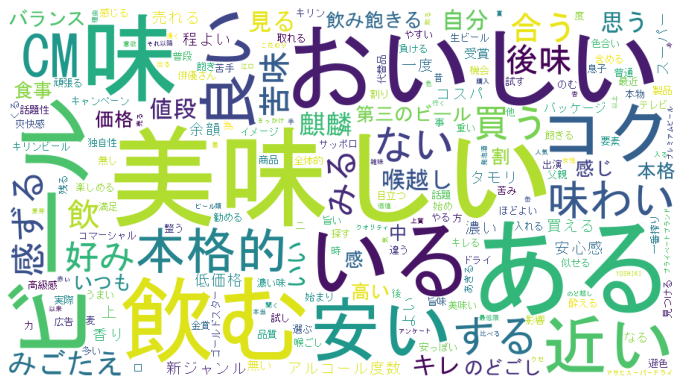

In [13]:
# ワードクラウド生成用に値を入力する

# font_path=fpath 「自然言語処理を行うための初期設定」で指定した「msgothic.ttc」
# ワードクラウドで生成する画像の横幅（width）や高さ（height）の指定など

# collocations = Falseについて　
# collocations = Trueだと複数で並んでいる単語「ビール 美味い」を1つの単語として表示してしまう
# 恐れがあるのでそうしないよう「False」に設定する
# generateの引数に文字列化した「wc_str」を代入
wordcloud = WordCloud(
    font_path=fpath,
    width=900, height=500, 
    background_color="white",
    max_words=500, 
    max_font_size=150, 
    min_font_size=4, 
    collocations = False
).generate(wc_str)

# Matplotlibで描画する図のサイズなど指定
plt.figure(figsize=(12,12))
# plt.imshowの引数にwordcloudを指定
plt.imshow(wordcloud)
# 座標軸の設定　今回は不要なのでoff
plt.axis("off")

plt.show()